# Logistic Regression Assumptions

In [67]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import math
from sklearn.linear_model import LogisticRegression
from scipy import stats

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


In [68]:
# Load cleaned data
listings_df = pd.read_csv(os.path.join('data', 'yvr_listing_data_cleaned.csv'))

In [69]:
## Assumption 1 — Linearity of independent variables and log-odds
# This assumption means that relationships between the continuous predictors and the logit (log odds) is linear.
# So the continuous variable should be filtered mannually
# Box Tidwell only works for positive values. Hence, drop values where x = 0
var = listings_df.columns.tolist()
continuous_var = ['price','host_response_rate',"review_scores_checkin","review_scores_cleanliness"]
df_yvr_1 = listings_df.drop(listings_df[listings_df.price == 0].index)
df_yvr_1 = df_yvr_1.drop(listings_df[listings_df.host_response_rate == 0].index)
df_yvr_1 = df_yvr_1.drop(listings_df[listings_df.review_scores_checkin == 0].index)
df_yvr_1 = df_yvr_1.drop(listings_df[listings_df.review_scores_cleanliness == 0].index)
print(df_yvr_1[['price','host_response_rate','review_scores_checkin','review_scores_cleanliness','legal_listing']].head(10))

   price  host_response_rate  review_scores_checkin  \
0  215.0               100.0                   4.83   
1  150.0               100.0                   4.96   
2  135.0               100.0                   4.85   
3  143.0               100.0                   4.74   
4  100.0               100.0                   4.87   
5  300.0               100.0                   4.94   
6  169.0               100.0                   4.88   
7  127.0               100.0                   4.51   
8  175.0               100.0                   4.97   
9  125.0               100.0                   4.90   

   review_scores_cleanliness  legal_listing  
0                       4.81            1.0  
1                       4.96            0.0  
2                       4.93            1.0  
3                       4.74            1.0  
4                       4.87            1.0  
5                       5.00            1.0  
6                       4.74            0.0  
7                       4.

In [70]:
# Logistic Regression with statsmodel 
# Inclusion of interaction term (logit transform) as part of Box-Tidwell test

df_yvr_lt = df_yvr_1 .copy()

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var:
    df_yvr_lt[f'{var}:Log_{var}'] = df_yvr_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_yvr_lt.head()

,host_response_rate,number_of_reviews,availability_365,availability_30,has_availability,price,host_response_time,host_verifications,host_total_listings_count,host_has_profile_pic,...,neighbourhood_cleansed_Strathcona,neighbourhood_cleansed_Sunset,neighbourhood_cleansed_Victoria-Fraserview,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Point Grey,legal_listing,price:Log_price,host_response_rate:Log_host_response_rate,review_scores_checkin:Log_review_scores_checkin,review_scores_cleanliness:Log_review_scores_cleanliness
0,100.0,476.0,108.0,4.0,1.0,215.0,1.00,0.5,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1154.687176,460.517019,7.606508,7.555053
1,100.0,99.0,40.0,9.0,1.0,150.0,1.00,0.5,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,751.595294,460.517019,7.942972,7.942972
2,100.0,269.0,124.0,5.0,1.0,135.0,0.75,0.5,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,662.212095,460.517019,7.658047,7.865021
3,100.0,51.0,37.0,4.0,1.0,143.0,0.75,0.5,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,709.686782,460.517019,7.375616,7.375616
4,100.0,230.0,155.0,6.0,1.0,100.0,1.00,0.5,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,460.517019,460.517019,7.709667,7.709667


In [71]:
# Keep columns related to continuous variables
cols_to_keep = continuous_var + df_yvr_lt.columns.tolist()[-len(continuous_var):]
cols_to_keep

# Redefine independent variables to include interaction terms
X_lt = df_yvr_lt[cols_to_keep]
y_lt = df_yvr_lt['legal_listing']

X_lt = sm.add_constant(X_lt, prepend=False)

# # Build model and fit the data (using statsmodel's Logit)
# logit_results = GLM(y_lt, X_lt, family=families.Binomial()).fit()

# Build model and fit the data (using statsmodel's Logit)
logit_model = sm.Logit(y_lt, X_lt)
logit_results = logit_model.fit(maxiter=100000)

# Display summary results
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.474684
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          legal_listing   No. Observations:                 3573
Model:                          Logit   Df Residuals:                     3564
Method:                           MLE   Df Model:                            8
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.09786
Time:                        12:40:55   Log-Likelihood:                -1696.0
converged:                       True   LL-Null:                       -1880.0
Covariance Type:            nonrobust   LLR p-value:                 1.317e-74
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
price             

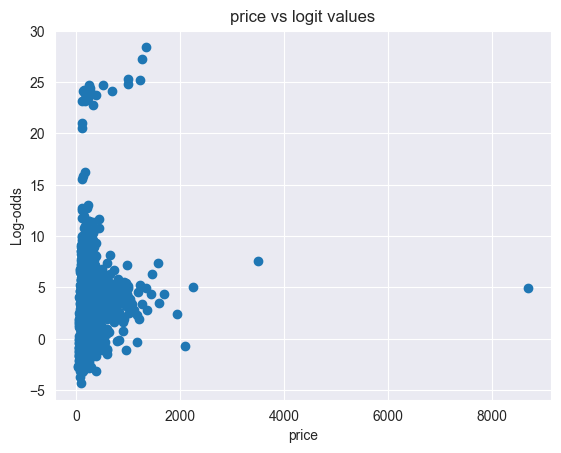

In [72]:
# Visual Check
# Define dependent and independent variables
X_cols = listings_df.columns.to_list()[:-1]
X = listings_df[X_cols].drop(['room_type_Hotel room', 'room_type_Shared room'], axis=1)
y = listings_df['legal_listing']

# Add constant
X = sm.add_constant(X, prepend=False)

# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = listings_df['price'].values, y = log_odds);
plt.title("price vs logit values")
plt.xlabel("price")
plt.ylabel("Log-odds")
plt.show()
# Confirming that there is no logit linearity for the 'price' variable 

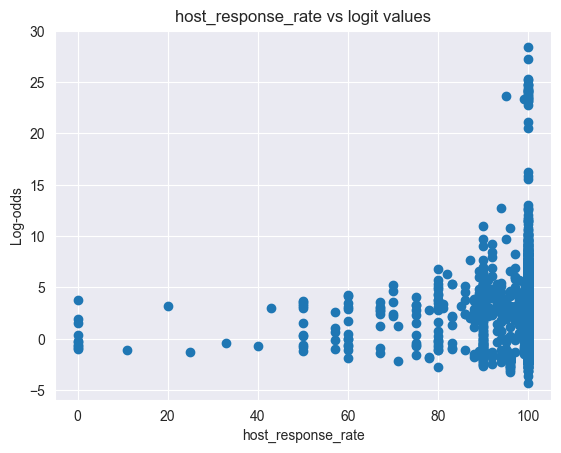

In [73]:
# Visualize predictor variable vs logit values for 'host_response_rate'
plt.scatter(x = listings_df['host_response_rate'].values, y = log_odds);
plt.title("host_response_rate vs logit values")
plt.xlabel("host_response_rate")
plt.ylabel("Log-odds")
plt.show()

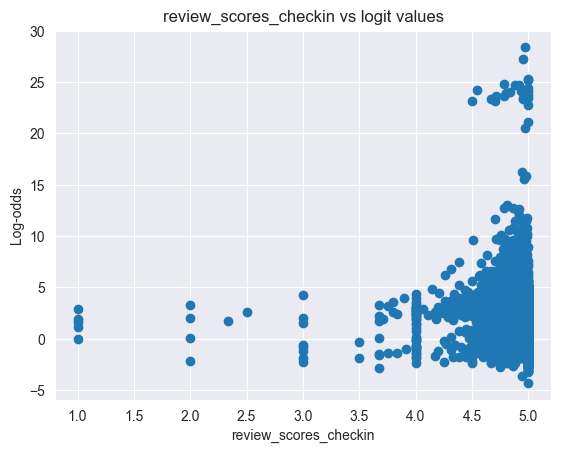

In [74]:
# Visualize predictor variable vs logit values for 'review_scores_checkin'
plt.scatter(x = listings_df['review_scores_checkin'].values, y = log_odds);
plt.title("review_scores_checkin vs logit values")
plt.xlabel("review_scores_checkin")
plt.ylabel("Log-odds")
plt.show()

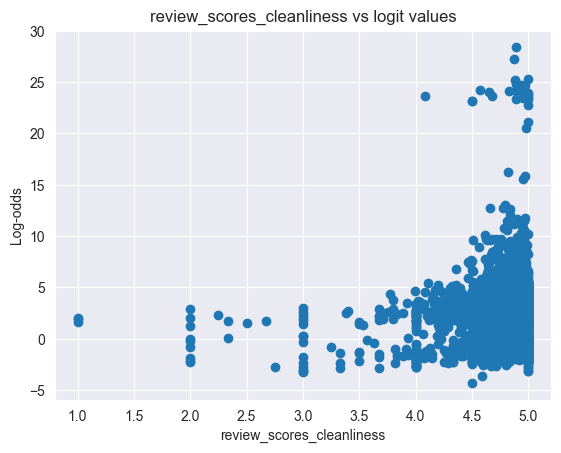

In [75]:
# Visualize predictor variable vs logit values for 'review_scores_cleanliness'
plt.scatter(x = listings_df['review_scores_cleanliness'].values, y = log_odds);
plt.title("review_scores_cleanliness vs logit values")
plt.xlabel("review_scores_cleanliness")
plt.ylabel("Log-odds")
plt.show()

In [76]:
# the 'price' and 'review_scores_checkin' violate the assumption, 
# so we need to transform them so that find the transformation that could fit the relationship with logit-odds

# replace price and review_scores_checkin value with their log tansformation
listings_df_0 = listings_df.copy()
listings_df_0['log_price'] = listings_df_0['price'].apply(lambda x: np.log(x) if x !=0 else 0)
listings_df_0['logmul_review_scores_checkin'] = listings_df_0['review_scores_checkin'].apply(lambda x: x * np.log(x) if x !=0 else 0)
listings_df_0 = listings_df_0.drop(['price','review_scores_checkin','room_type_Hotel room','room_type_Shared room'], axis=1)

# fit the logistic regression model
X_0 = listings_df_0.drop('legal_listing', axis=1)
y_0 = listings_df_0['legal_listing']
X_0 = sm.add_constant(X_0)

logit_model_0 = sm.Logit(y_0, X_0)
result_0 = logit_model_0.fit()
print(result_0.summary())

# The linearity relation of 'review_scores_checkin' can be built by using logarithmic multiplication transformation,  (the p-value of 'log_review_scores_checkin' is 0.039 less than 0.05) 
# The linearity relation of 'price' can be built by using log transformation,  (the p-value of 'log_price' is 0.039 less than 0.05) 

         Current function value: 0.258708
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          legal_listing   No. Observations:                 3583
Model:                          Logit   Df Residuals:                     3540
Method:                           MLE   Df Model:                           42
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                  0.5089
Time:                        12:40:58   Log-Likelihood:                -926.95
converged:                      False   LL-Null:                       -1887.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               0.4831      1.582 

In [77]:
# Move the transformed colunms to head
listings_df_0 = listings_df_0[['log_price', 'logmul_review_scores_checkin'] + 
                               [col for col in listings_df_0.columns if col not in ['log_price', 'logmul_review_scores_checkin']]]
listings_df_0

,log_price,logmul_review_scores_checkin,host_response_rate,number_of_reviews,availability_365,availability_30,has_availability,host_response_time,host_verifications,host_total_listings_count,...,neighbourhood_cleansed_Renfrew-Collingwood,neighbourhood_cleansed_Riley Park,neighbourhood_cleansed_Shaughnessy,neighbourhood_cleansed_South Cambie,neighbourhood_cleansed_Strathcona,neighbourhood_cleansed_Sunset,neighbourhood_cleansed_Victoria-Fraserview,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Point Grey,legal_listing
0,5.370638,7.606508,100.0,476.0,108.0,4.0,1.0,1.00,0.50,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,5.010635,7.942972,100.0,99.0,40.0,9.0,1.0,1.00,0.50,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.905275,7.658047,100.0,269.0,124.0,5.0,1.0,0.75,0.50,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.962845,7.375616,100.0,51.0,37.0,4.0,1.0,0.75,0.50,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4.605170,7.709667,100.0,230.0,155.0,6.0,1.0,1.00,0.50,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,5.298317,8.047190,100.0,1.0,74.0,15.0,1.0,1.00,0.50,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3579,5.147494,8.047190,100.0,2.0,146.0,7.0,1.0,1.00,0.75,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3580,5.991465,8.047190,94.0,1.0,361.0,26.0,1.0,0.75,0.75,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3581,5.771441,8.047190,100.0,1.0,81.0,21.0,1.0,1.00,0.25,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [78]:
# Applying Box-Tidwell test to the fixed dataset
var_1 = listings_df_0.columns.tolist()
continuous_var_1 = ['log_price','logmul_review_scores_checkin']

listings_df_1 = listings_df_0.copy()

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var_1:
    listings_df_1[f'{var}:Log_{var}'] = listings_df_1[var].apply(lambda x: x * np.log(x)) #np.log = natural log

# Keep columns related to continuous variables
cols_to_keep_1 = continuous_var_1 + listings_df_1.columns.tolist()[-len(continuous_var_1):]
cols_to_keep_1

# check the NAN value of X_1 and delete the rows
np.where(np.isnan(listings_df_1[cols_to_keep_1]).any(axis=1))[0]
listings_df_1 = listings_df_1.drop([2608, 2992, 3080, 3163, 3390])
listings_df_1 = listings_df_1.drop([1724, 57, 844, 833, 499, 1459, 629, 1903, 1727, 1102, 1630, 1759, 1794, 882], axis=0)


# Redefine independent variables to include interaction terms
X_1 = listings_df_1[cols_to_keep_1]
y_1 = listings_df_1['legal_listing']
X_1 = sm.add_constant(X_1)

# Build model and fit the data (using statsmodel's Logit)
logit_model_1 = sm.Logit(y_1, X_1)
logit_results_1 = logit_model_1.fit()

# Display summary results
print(logit_results_1.summary())

Optimization terminated successfully.
         Current function value: 0.468916
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          legal_listing   No. Observations:                 3564
Model:                          Logit   Df Residuals:                     3559
Method:                           MLE   Df Model:                            4
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                  0.1033
Time:                        12:40:58   Log-Likelihood:                -1671.2
converged:                       True   LL-Null:                       -1863.8
Covariance Type:            nonrobust   LLR p-value:                 4.573e-82
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const 

Slope: 3.8781568423069723
Intercept: -5.697922881986016
R-squared: 0.044250983206094045
P-value: 5.5396352686345895e-37
Standard Error: 0.3017757111300134


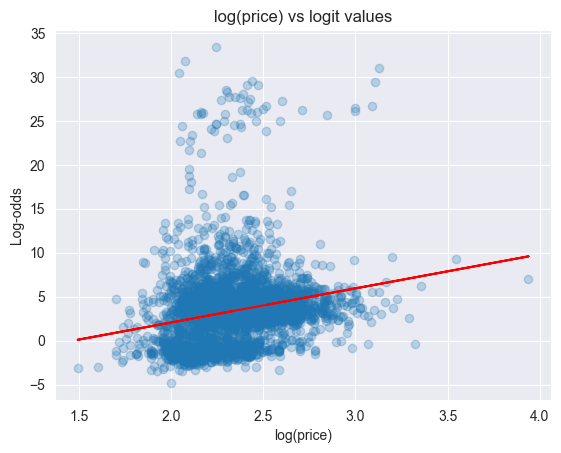

In [79]:
# Visual Check
# Define dependent and independent variables
listings_df = listings_df.drop([1724, 57, 844, 833, 499, 1459, 629, 1903, 1727, 1102, 1630, 1759, 1794, 882], axis=0)

X_cols = listings_df.columns.to_list()[:-1]
X = listings_df[X_cols].drop(['room_type_Hotel room', 'room_type_Shared room'], axis=1)
y = listings_df['legal_listing']



# Add constant
X = sm.add_constant(X, prepend=False)

# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)


# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Calculate linear regression between log(price) and logit values
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(listings_df['price'].values), log_odds)

# Print the results
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("Standard Error:", std_err)

# Visualize predictor continuous variable vs logit values (Price)
plt.scatter(x = np.log10(listings_df['price'].values), y = log_odds, alpha = 0.25);
plt.title("log(price) vs logit values")
plt.xlabel("log(price)")
plt.ylabel("Log-odds")

# Add the slope line
x = np.log10(listings_df['price'].values)
y = slope * x + intercept
plt.plot(x, y, color='red')

plt.savefig('log_price_vs_logit.png', transparent=True)
plt.show()

In [32]:
## Assumption 2 — No strongly influential outliers

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          legal_listing   No. Observations:                 3583
Model:                            GLM   Df Residuals:                     3540
Model Family:                Binomial   Df Model:                           42
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -928.63
Date:                Wed, 06 Dec 2023   Deviance:                       1857.3
Time:                        12:20:31   Pearson chi2:                 3.89e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.4145
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [33]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()
     

,cooks_d,std_resid
0,1.448033e-11,0.029364
1,2.693768e-03,0.796688
2,7.840719e-06,0.081388
3,1.034099e-03,0.395302
4,6.064458e-06,0.077876


Threshold for Cook Distance = 0.0011163829193413341


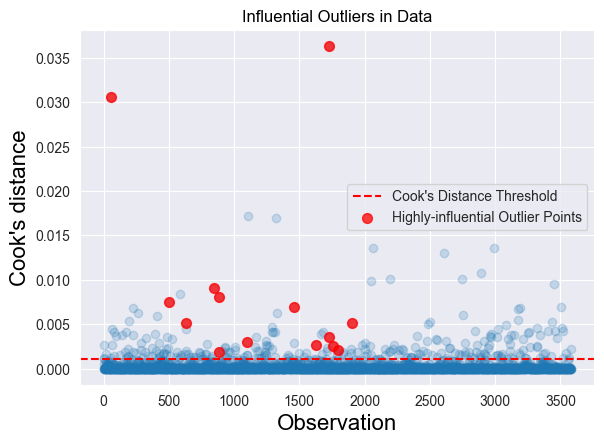

In [42]:
# Set Cook's distance threshold
cook_threshold = 4 / len(listings_df)
print(f"Threshold for Cook Distance = {cook_threshold}")

# Plot influence measures (Cook's distance)
fig, ax = plt.subplots()
influence.plot_index(y_var="cooks", threshold=cook_threshold, ax=ax, alpha=0.2)  # Set alpha here
axhline = ax.axhline(y=cook_threshold, ls="--", color='red')

# Remove existing labels
for text in ax.texts:
    text.set_visible(False)

# Highlight points with std_resid > 3
highlight_indices = diagnosis_df[diagnosis_df['std_resid'] > 2.5].index
scatter = ax.scatter(
    highlight_indices,
    diagnosis_df.loc[highlight_indices, 'cooks_d'],
    color='red',  # Set a color for the highlighted points
    marker='o',   # Set a marker style for the highlighted points
    alpha=0.75,    # Set transparency for the highlighted points
    s=50          # Set marker size
)


fig.tight_layout(pad=2)

plt.legend([axhline, scatter], ['Cook\'s Distance Threshold', 'Highly-influential Outlier Points'], loc='center right')

plt.title("Influential Outliers in Data")

fig.tight_layout(pad=2)
plt.savefig('outliers.png', transparent=True)
plt.show()

In [35]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(listings_df)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 7.2%


In [36]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 2.5)]
prop_extreme = round(100*(len(extreme) / len(listings_df)),1)
# Display top most influential outliers
extreme.sort_values("cooks_d", ascending=False)

,cooks_d,std_resid
1724,0.036355,16.050794
57,0.030566,52.380381
844,0.009038,11.854802
883,0.008019,2.638577
499,0.007459,6.412854
1459,0.006941,3.977317
629,0.005187,4.854631
1903,0.005130,2.919283
1727,0.003544,6.396491
1102,0.003014,3.156169


In [37]:
# Deep dive into index 1724 (extreme outlier)
print(listings_df.iloc[1724])

host_response_rate                                 100.00
number_of_reviews                                  134.00
availability_365                                    73.00
availability_30                                     13.00
has_availability                                     1.00
price                                              129.00
host_response_time                                   1.00
host_verifications                                   0.50
host_total_listings_count                            6.00
host_has_profile_pic                                 1.00
host_acceptance_rate                                99.00
number_of_reviews_l30d                               6.00
review_scores_checkin                                4.80
beds                                                 3.00
calculated_host_listings_count_private_rooms         0.00
instant_bookable                                     0.00
review_scores_cleanliness                            4.88
host_identity_

In [38]:
# delete all the high influential outliers row: 1724, 57, 844, 499, 1459, 629, 1727, 1102, 1759, 1794, 882
listings_df_fixed = listings_df_0.drop([1724, 57, 844, 499, 1459, 629, 1727, 1102, 1759, 1794, 882], axis=0)

# check if they are deleted
origin_row = listings_df_0.shape[0]
fixed_row = listings_df_fixed.shape[0]
print(f'the fixed row is {fixed_row}; the origin row is {origin_row}.\nThere are {origin_row - fixed_row} rows have been deleted.')

# save the fixed data into csv
listings_df_fixed.to_csv('data/yvr_listing_data_cleaned_fixed.csv', index=False)

the fixed row is 3572; the origin row is 3583.
There are 11 rows have been deleted.
